In [1]:
import numpy as np

# path of npy file
file_path_train = r"F:\Datasets\fMRI_RestingState\train.npy"
file_path_test = r"F:\Datasets\fMRI_RestingState\test.npy"

# load file
data_train = np.load(file_path_train)
data_test = np.load(file_path_train)

# print data
print(data_train)
print(data_test)

# check shape
print("Shape train:", data_train.shape)
print("Shape test:", data_test.shape)

# check data type
print("Datatype train:", data_train.dtype)
print("Datatype test:", data_test.dtype)




[[[ 3.77252132e-01  8.36436987e-01  9.52367425e-01 ... -1.27082384e+00
   -2.04386735e+00 -1.68724239e+00]
  [ 3.85770738e-01  8.93172741e-01  9.65170205e-01 ... -1.38609648e+00
   -2.16900992e+00 -1.78248298e+00]
  [ 4.52007174e-01  1.07923651e+00  1.10089386e+00 ... -5.94564378e-01
   -1.65408635e+00 -1.94501257e+00]
  ...
  [ 1.71183228e-01  7.76966035e-01 -1.50878429e+00 ...  3.64542007e-01
    2.17234599e-03 -8.63370858e-03]
  [-1.25982508e-01  3.04414272e-01 -2.03240299e+00 ...  5.65380096e-01
    1.10789649e-01  3.56410265e-01]
  [-2.16325998e-01 -4.53923225e-01 -2.08188772e+00 ...  6.41844988e-01
    1.17849775e-01  6.33444369e-01]]

 [[ 1.52827525e+00  1.38610888e+00 -1.55047762e+00 ...  1.72840536e-01
    1.04165399e+00  8.56195569e-01]
  [ 1.56439173e+00  1.41681588e+00 -1.56560755e+00 ...  1.53422102e-01
    1.06025791e+00  8.82538259e-01]
  [ 1.35226202e+00  1.32228017e+00 -1.17009115e+00 ... -5.86843669e-01
    5.05019844e-01  8.25134754e-01]
  ...
  [-8.72815493e-03 -2.3

In [2]:
import numpy as np

def compute_fc_matrices(X):
    """
    X: (n_subjects, n_time, n_rois)
    returns: FC (n_subjects, n_rois, n_rois)
    """
    n_subj, T, R = X.shape
    FC = np.zeros((n_subj, R, R), dtype=np.float32)

    for i in range(n_subj):
        ts = X[i]  # (T, R)

        # z-score each ROI time series (recommended)
        ts = (ts - ts.mean(axis=0, keepdims=True)) / (ts.std(axis=0, keepdims=True) + 1e-8)

        # correlation between ROIs
        fc = np.corrcoef(ts, rowvar=False)  # (R, R)

        # clean NaNs if any (rare but possible if an ROI is constant)
        fc = np.nan_to_num(fc, nan=0.0, posinf=0.0, neginf=0.0)

        FC[i] = fc.astype(np.float32)

    return FC

FC_train = compute_fc_matrices(data_train)
FC_test  = compute_fc_matrices(data_test)

print("FC train:", FC_train.shape)  # (15, 116, 116)
print("FC test:", FC_test.shape)

FC train: (15, 116, 116)
FC test: (15, 116, 116)


In [3]:
import numpy as np

def threshold_top_percent(fc, top_percent=10):
    """
    fc: (R, R) correlation matrix
    keeps top_percent% of absolute off-diagonal edges
    returns adjacency matrix (R, R) with weights
    """
    R = fc.shape[0]
    A = np.abs(fc).copy()
    np.fill_diagonal(A, 0)

    # number of edges to keep (off-diagonal, undirected)
    n_possible = R * (R - 1) // 2
    k = int(np.floor(n_possible * (top_percent / 100.0)))
    if k < 1:
        raise ValueError("top_percent too small.")

    # get threshold value from upper triangle
    triu_vals = A[np.triu_indices(R, k=1)]
    thresh = np.partition(triu_vals, -k)[-k]

    # keep edges >= thresh
    keep = (A >= thresh).astype(np.float32)
    W = fc * keep  # keep signed weights (or use A if you want abs weights)

    # make perfectly symmetric
    W = (W + W.T) / 2
    np.fill_diagonal(W, 0)
    return W

In [4]:
import networkx as nx
import numpy as np

def graph_metrics_from_adj(W):
    """
    W: (R, R) weighted adjacency (can be signed)
    returns dict of graph-level metrics
    """
    # Use absolute weights for most graph metrics (typical)
    A = np.abs(W)
    G = nx.from_numpy_array(A)  # undirected weighted graph

    # Strength (weighted degree)
    strength = np.array([d for _, d in G.degree(weight="weight")], dtype=np.float32)

    # Clustering (weighted)
    clustering = nx.clustering(G, weight="weight")
    clustering_vals = np.array(list(clustering.values()), dtype=np.float32)

    # For shortest paths, define "distance" as inverse weight
    # (bigger correlation -> shorter distance)
    for u, v, w in G.edges(data=True):
        weight = w["weight"]
        w["distance"] = 1.0 / (weight + 1e-8)

    # Connectedness check
    is_connected = nx.is_connected(G)

    # Average shortest path (only if connected)
    if is_connected:
        avg_path_len = nx.average_shortest_path_length(G, weight="distance")
    else:
        avg_path_len = np.nan

    # Global efficiency (manual; works even if disconnected)
    # efficiency = mean(1/d_ij) over i!=j on shortest path distances
    lengths = dict(nx.all_pairs_dijkstra_path_length(G, weight="distance"))
    R = G.number_of_nodes()
    invd_sum = 0.0
    count = 0
    for i in range(R):
        for j in range(R):
            if i == j:
                continue
            d = lengths[i].get(j, None)
            if d is not None and d > 0:
                invd_sum += 1.0 / d
                count += 1
    global_eff = invd_sum / count if count > 0 else np.nan

    return {
        "n_nodes": G.number_of_nodes(),
        "n_edges": G.number_of_edges(),
        "mean_strength": float(np.mean(strength)),
        "mean_clustering": float(np.mean(clustering_vals)),
        "avg_path_len": float(avg_path_len) if avg_path_len == avg_path_len else np.nan,
        "global_efficiency": float(global_eff) if global_eff == global_eff else np.nan,
        "connected": bool(is_connected),
    }

In [5]:
def compute_metrics_for_group(FC, top_percent=10):
    metrics = []
    for i in range(FC.shape[0]):
        W = threshold_top_percent(FC[i], top_percent=top_percent)
        m = graph_metrics_from_adj(W)
        metrics.append(m)
    return metrics

train_metrics = compute_metrics_for_group(FC_train, top_percent=10)
test_metrics  = compute_metrics_for_group(FC_test, top_percent=10)

print(train_metrics[0])

{'n_nodes': 116, 'n_edges': 667, 'mean_strength': 7.230718612670898, 'mean_clustering': 0.3531937301158905, 'avg_path_len': nan, 'global_efficiency': 0.2541727987750529, 'connected': False}


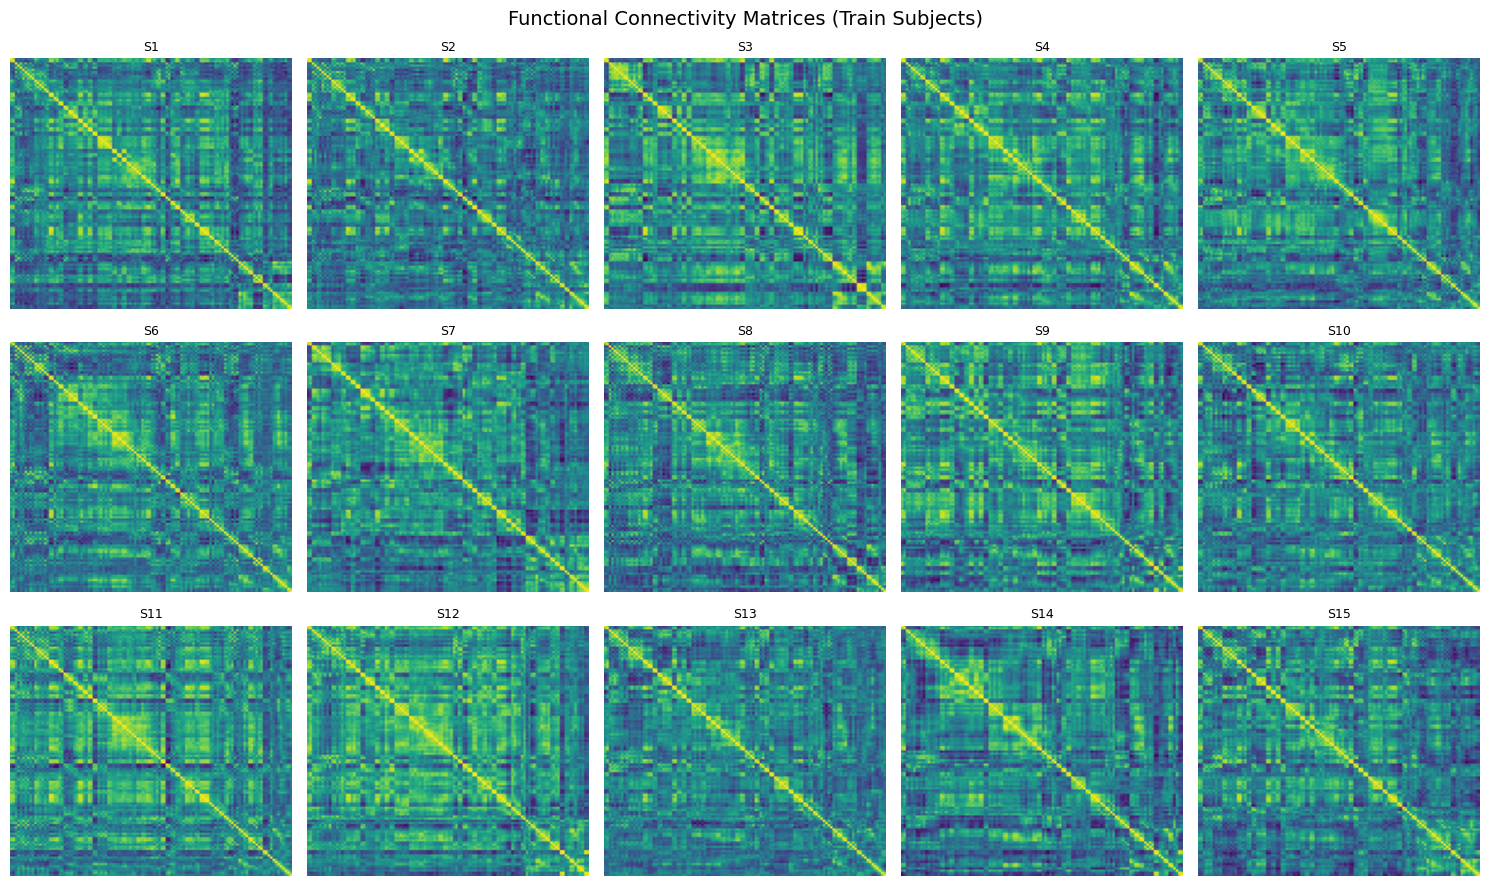

In [6]:
import matplotlib.pyplot as plt
import numpy as np

n_subjects = FC_train.shape[0]

rows = 3
cols = 5

plt.figure(figsize=(15, 9))

for i in range(n_subjects):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(FC_train[i], aspect="auto")
    plt.title(f"S{i+1}", fontsize=9)
    plt.axis("off")

plt.suptitle("Functional Connectivity Matrices (Train Subjects)", fontsize=14)
plt.tight_layout()
plt.show()

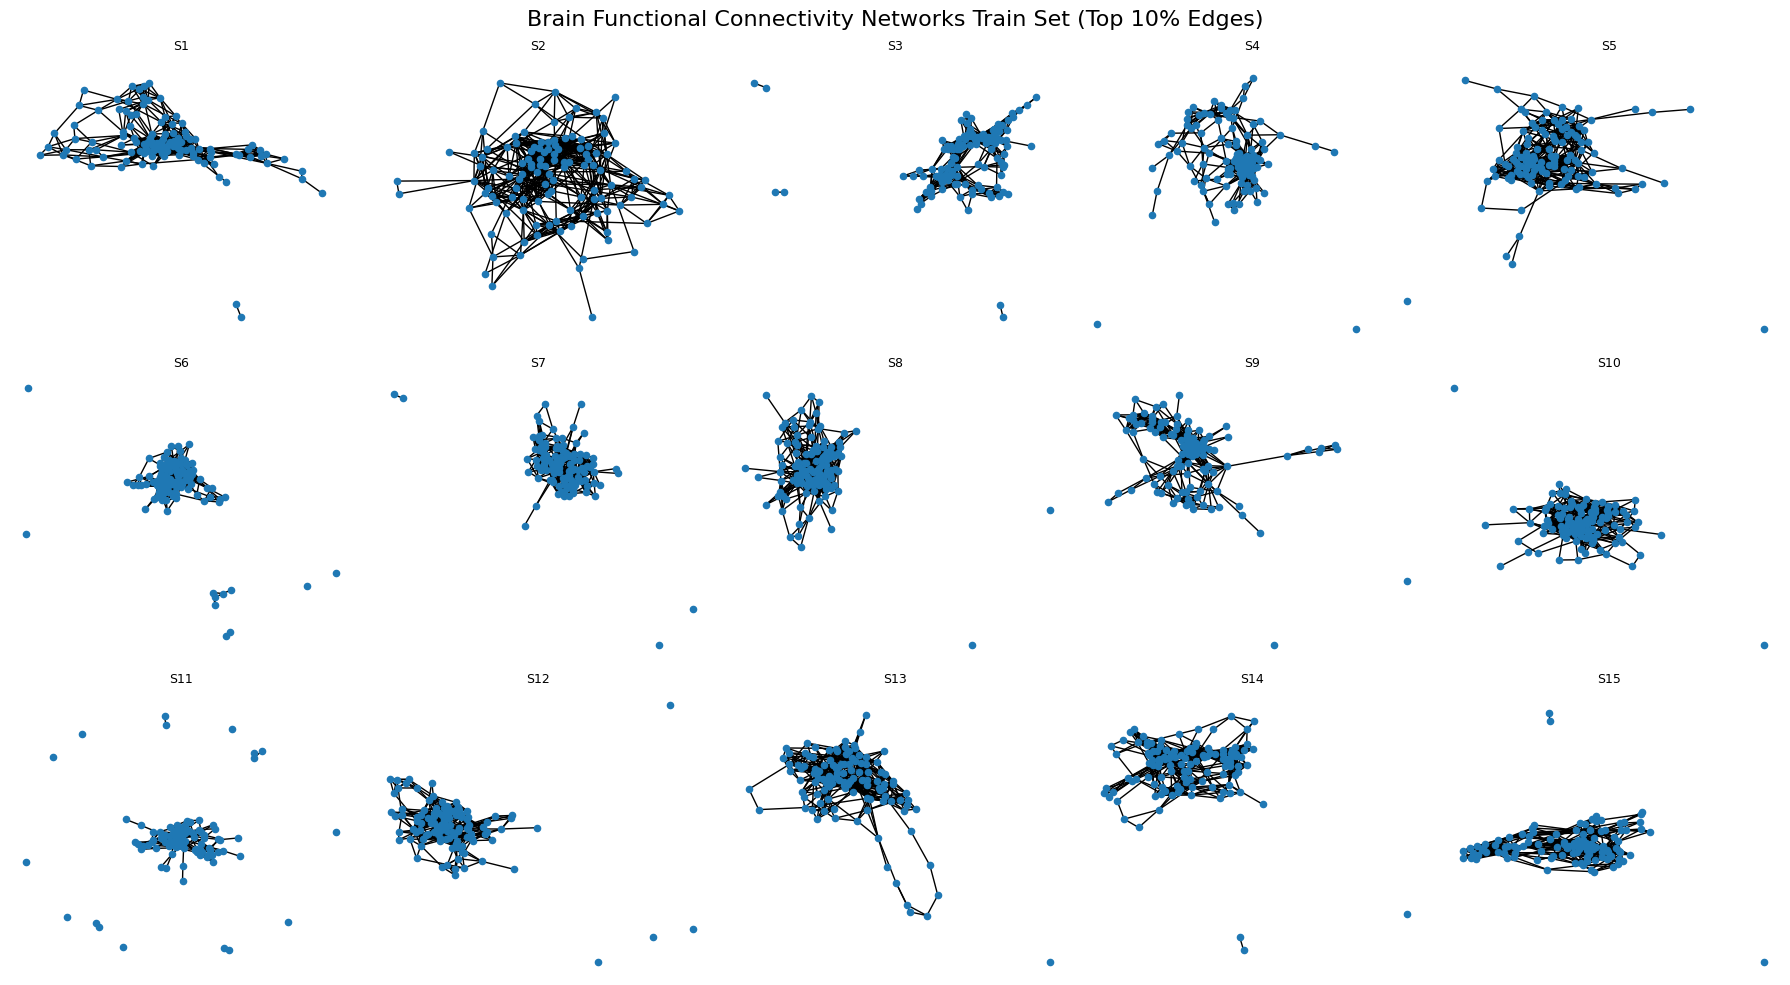

In [7]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

n_subjects = FC_train.shape[0]

rows = 3
cols = 5

plt.figure(figsize=(18, 10))

for i in range(n_subjects):

    W = threshold_top_percent(FC_train[i], top_percent=10)
    G = nx.from_numpy_array(np.abs(W))

    pos = nx.spring_layout(G, seed=42)

    plt.subplot(rows, cols, i + 1)

    nx.draw(
        G,
        pos,
        node_size=20,
        with_labels=False
    )

    plt.title(f"S{i+1}", fontsize=9)

plt.suptitle("Brain Functional Connectivity Networks Train Set (Top 10% Edges)", fontsize=16)
plt.tight_layout()
plt.show()

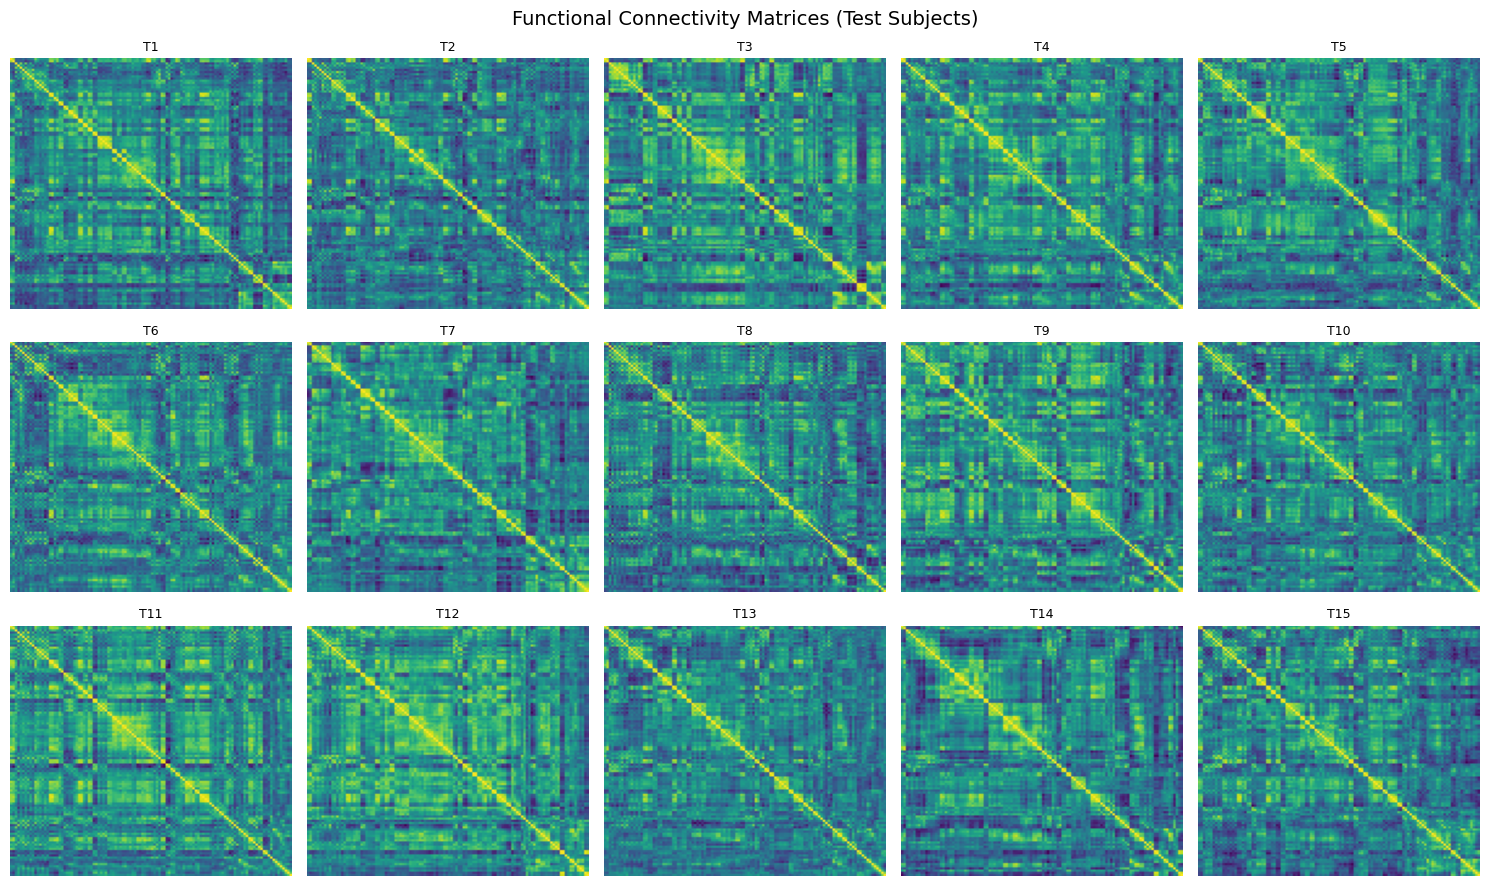

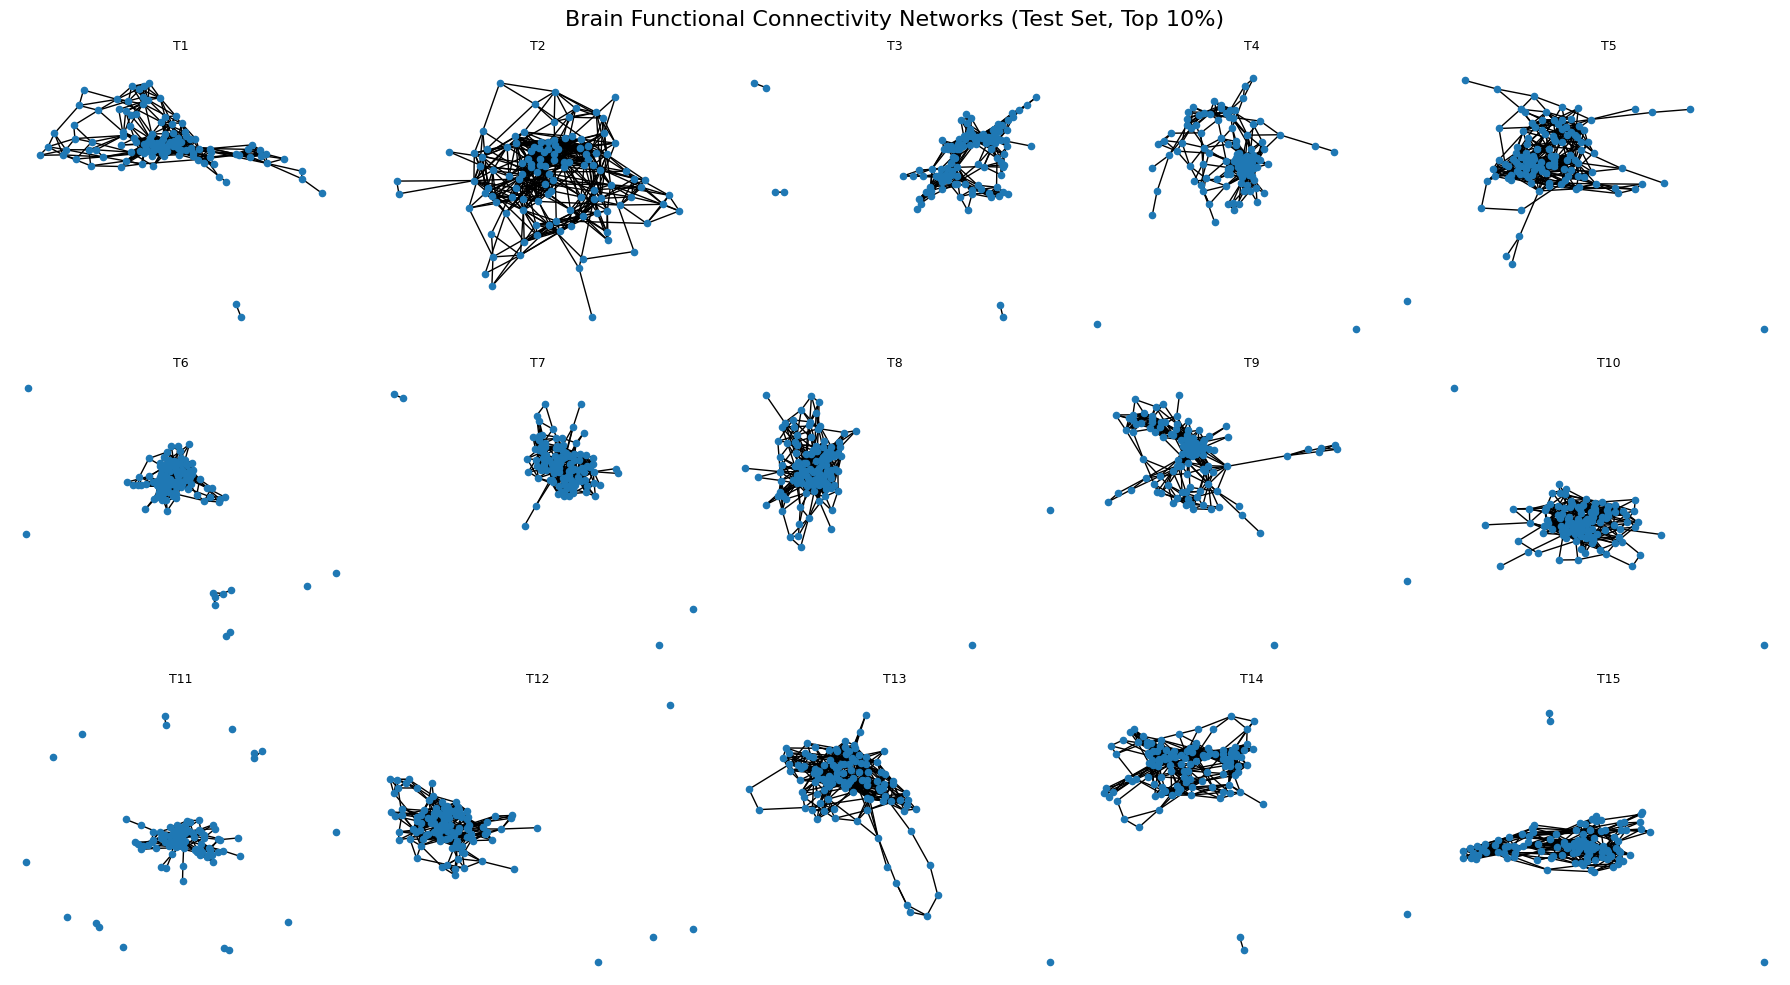


Mean Strength
Train -> mean: 7.2129, std: 0.3951
Test  -> mean: 7.2129, std: 0.3951

Mean Clustering Coefficient
Train -> mean: 0.3290, std: 0.0371
Test  -> mean: 0.3290, std: 0.0371

Global Efficiency
Train -> mean: 0.2654, std: 0.0151
Test  -> mean: 0.2654, std: 0.0151


C:\Users\User\AppData\Local\Temp\ipykernel_22800\2040941709.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_strength, test_strength], labels=["Train", "Test"])
C:\Users\User\AppData\Local\Temp\ipykernel_22800\2040941709.py:101: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_clust, test_clust], labels=["Train", "Test"])
C:\Users\User\AppData\Local\Temp\ipykernel_22800\2040941709.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_eff, test_eff], labels=["Train", "Test"])


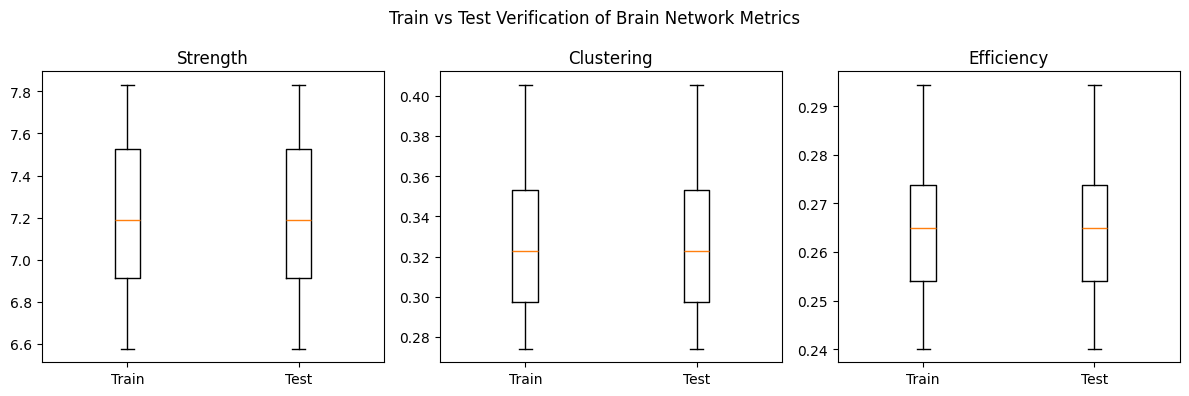


FINAL METRICS TABLE:
   Group  Subject  Nodes  Edges  MeanStrength  MeanClustering  \
0  Train        1    116    667      7.230719        0.353194   
1  Train        2    116    667      6.714387        0.273977   
2  Train        3    116    667      7.832869        0.405558   
3  Train        4    116    667      7.367675        0.350587   
4  Train        5    116    667      7.133430        0.284138   

   GlobalEfficiency  Connected  
0          0.254173      False  
1          0.246552       True  
2          0.280489      False  
3          0.250711      False  
4          0.259725      False  


In [8]:
# ===============================
# TEST SET ANALYSIS & VERIFICATION
# ===============================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx


# -------------------------------
# 1. VISUALIZE TEST FC MATRICES
# -------------------------------

n_subjects = FC_test.shape[0]
rows, cols = 3, 5

plt.figure(figsize=(15, 9))

for i in range(n_subjects):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(FC_test[i], aspect="auto")
    plt.title(f"T{i+1}", fontsize=9)
    plt.axis("off")

plt.suptitle("Functional Connectivity Matrices (Test Subjects)", fontsize=14)
plt.tight_layout()
plt.show()


# -------------------------------
# 2. VISUALIZE TEST BRAIN NETWORKS
# -------------------------------

plt.figure(figsize=(18, 10))

for i in range(n_subjects):

    W = threshold_top_percent(FC_test[i], top_percent=10)
    G = nx.from_numpy_array(np.abs(W))
    pos = nx.spring_layout(G, seed=42)

    plt.subplot(rows, cols, i + 1)

    nx.draw(
        G,
        pos,
        node_size=20,
        with_labels=False
    )

    plt.title(f"T{i+1}", fontsize=9)

plt.suptitle("Brain Functional Connectivity Networks (Test Set, Top 10%)", fontsize=16)
plt.tight_layout()
plt.show()


# -------------------------------
# 3. EXTRACT METRICS FOR COMPARISON
# -------------------------------

def extract_metric(metrics, key):
    return np.array([m[key] for m in metrics], dtype=np.float32)

train_strength = extract_metric(train_metrics, "mean_strength")
test_strength  = extract_metric(test_metrics,  "mean_strength")

train_clust = extract_metric(train_metrics, "mean_clustering")
test_clust  = extract_metric(test_metrics,  "mean_clustering")

train_eff = extract_metric(train_metrics, "global_efficiency")
test_eff  = extract_metric(test_metrics,  "global_efficiency")


# -------------------------------
# 4. PRINT VERIFICATION SUMMARY
# -------------------------------

def summary(name, a, b):
    print(f"\n{name}")
    print(f"Train -> mean: {a.mean():.4f}, std: {a.std():.4f}")
    print(f"Test  -> mean: {b.mean():.4f}, std: {b.std():.4f}")

summary("Mean Strength", train_strength, test_strength)
summary("Mean Clustering Coefficient", train_clust, test_clust)
summary("Global Efficiency", train_eff, test_eff)


# -------------------------------
# 5. BOXPLOT VERIFICATION FIGURE
# -------------------------------

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.boxplot([train_strength, test_strength], labels=["Train", "Test"])
plt.title("Strength")

plt.subplot(1, 3, 2)
plt.boxplot([train_clust, test_clust], labels=["Train", "Test"])
plt.title("Clustering")

plt.subplot(1, 3, 3)
plt.boxplot([train_eff, test_eff], labels=["Train", "Test"])
plt.title("Efficiency")

plt.suptitle("Train vs Test Verification of Brain Network Metrics")
plt.tight_layout()
plt.show()


# -------------------------------
# 6. CREATE FINAL RESULTS TABLE
# -------------------------------

def metrics_to_dataframe(metrics, group_name):
    rows = []
    for i, m in enumerate(metrics):
        row = {
            "Group": group_name,
            "Subject": i + 1,
            "Nodes": m["n_nodes"],
            "Edges": m["n_edges"],
            "MeanStrength": m["mean_strength"],
            "MeanClustering": m["mean_clustering"],
            "GlobalEfficiency": m["global_efficiency"],
            "Connected": m["connected"]
        }
        rows.append(row)
    return pd.DataFrame(rows)

df_train = metrics_to_dataframe(train_metrics, "Train")
df_test  = metrics_to_dataframe(test_metrics,  "Test")

df_all = pd.concat([df_train, df_test], ignore_index=True)

print("\nFINAL METRICS TABLE:")
print(df_all.head())